1. Ön işleme yapılmış veriyi okuma

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = "datasets/processed_thyroid_cancer_data.csv"
df = pd.read_csv(file_path)

print("İlk 5 Satır:")
print(df.head())

İlk 5 Satır:
   Age  TSH_Level  T3_Level  T4_Level  Nodule_Size  Gender_Male  \
0   66          9         1         6            1            1   
1   29          1         1        10            4            1   
2   86          6         2        10            4            1   
3   75          4         2        11            2            0   
4   35          9         2        10            2            0   

   Country_China  Country_Germany  Country_India  Country_Japan  ...  \
0              0                0              0              0  ...   
1              0                1              0              0  ...   
2              0                0              0              0  ...   
3              0                0              1              0  ...   
4              0                1              0              0  ...   

   Ethnicity_Middle Eastern  Family_History_Yes  Radiation_Exposure_Yes  \
0                         0                   0                       1   
1

2. Bağımlı ve Bağımsız değişkenleri ayırma

In [80]:
# Özellikler ve hedef değişkeni ayır
X = df.drop(columns=["Diagnosis_Malignant"])
y = df["Diagnosis_Malignant"]

# Eğitim ve test kümelerine ayırma (%70 eğitim - %30 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Eğitim Verisi:", X_train.shape, y_train.shape)
print("Test Verisi:", X_test.shape, y_test.shape)

Eğitim Verisi: (148883, 27) (148883,)
Test Verisi: (63808, 27) (63808,)


3. SMOTE ile veri dengesizliğini ortadan kaldırma

In [81]:
from imblearn.over_sampling import SMOTE

# SMOTE nesnesi oluştur
smote = SMOTE(random_state=42)

# Sadece eğitim verisine uygula!
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("SMOTE sonrası eğitim kümesi boyutu:", X_train_smote.shape, y_train_smote.shape)
print("Sınıf dağılımı (SMOTE sonrası):\n", y_train_smote.value_counts())

SMOTE sonrası eğitim kümesi boyutu: (228454, 27) (228454,)
Sınıf dağılımı (SMOTE sonrası):
 Diagnosis_Malignant
0    114227
1    114227
Name: count, dtype: int64


4. Karar Ağacı Modelini Oluşturma (Entropi Tabanlı)

In [82]:
from sklearn.tree import DecisionTreeClassifier

# Entropi kriterine göre model oluştur
#model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=42)
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
model.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

5. GridSearch ile en iyi parametre belirleme

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Parametre aralıkları tanımlanır
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV nesnesi oluşturulur
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',  # çok sınıf için uygun
    cv=5,
    n_jobs=-1,  # paralel çalıştırma
    verbose=1   # işlem süreci izlensin
)

# GridSearch eğitimi
grid.fit(X_train_smote, y_train_smote)

best_model = grid.best_estimator_

# En iyi parametreleri yazdır
print("En iyi parametreler:", grid.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
En iyi parametreler: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


6. Test Verisi ile Tahmin ve Performans Değerlendirmesi

Accuracy     | 0.7846
Recall       | 0.6781
Specificity  | 0.8773
Precision    | 0.6946
F1 Score     | 0.6852


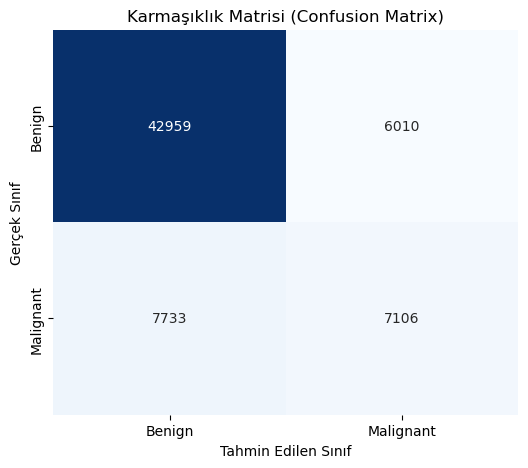

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Tahmin: GridSearch sonrası en iyi model
y_pred = best_model.predict(X_test)

# Metrikler ve karmaşıklık matrisi
cm = confusion_matrix(y_test, y_pred)

# TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

# Hesaplamalar
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
specificity = tn / (tn + fp)

# Metin tablosu
print(f"{'Accuracy':<12} | {accuracy:.4f}")
print(f"{'Recall':<12} | {recall:.4f}")
print(f"{'Specificity':<12} | {specificity:.4f}")
print(f"{'Precision':<12} | {precision:.4f}")
print(f"{'F1 Score':<12} | {f1:.4f}")


# 🎨 Görsel: Karmaşıklık Matrisi
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Karmaşıklık Matrisi (Confusion Matrix)")
plt.show()

7. ROC Eğrisi

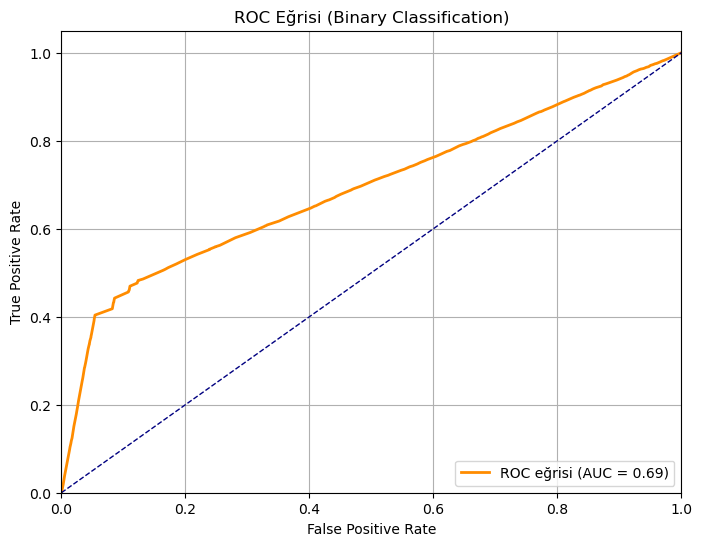

In [85]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Modelin tahmin olasılıkları (pozitif sınıf için)
y_score = best_model.predict_proba(X_test)[:, 1]

# ROC eğrisi için FPR, TPR ve AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# ROC Eğrisi çizimi
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC eğrisi (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi (Binary Classification)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

7. Karar Ağacı Görselleştirme

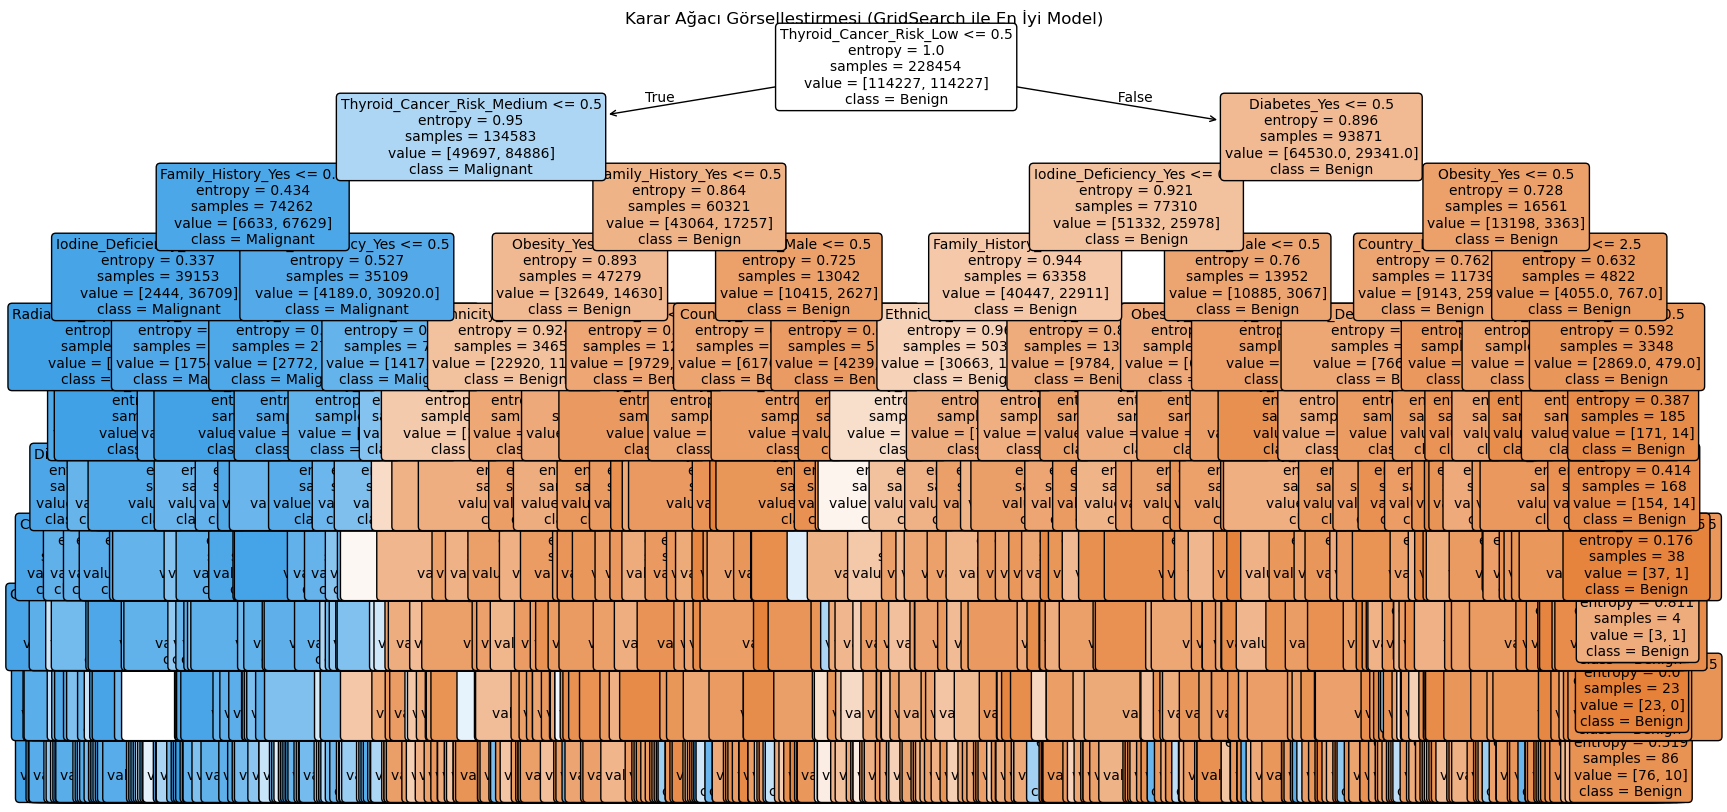

In [86]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    best_model,
    filled=True,
    feature_names=X.columns,
    class_names=["Benign", "Malignant"],
    rounded=True,
    fontsize=10
)
plt.title("Karar Ağacı Görselleştirmesi (GridSearch ile En İyi Model)")
plt.show()